In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader
import json
from pathlib import Path
from transformer_lens.hook_points import HookPoint
from transformers import AutoTokenizer, AutoModelForCausalLM, PaliGemmaForConditionalGeneration
from sklearn.model_selection import train_test_split
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

# from random import random
import random
def seed_everywhere(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)    
SEED = 42
MAX_SEQ_LEN = 64 # location to truncate our inputs
DEVICE_1 = 'cuda:1'
DEVICE_2 = 'cuda:2' # the second GPU
NUM_CLASSES = 0
seed_everywhere(SEED)


/opt/conda/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/opt/conda/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was prov

# exp

In [2]:
class ActivationDataset(Dataset):
    """Dataset for model activations with labels"""
    def __init__(self, activations, labels):
        self.activations = torch.tensor(activations, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.activations)
    
    def __getitem__(self, idx):
        return self.activations[idx], self.labels[idx]

class LinearProbe(nn.Module):
    """Simple linear probe for classification"""
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class LinearProbingExperiment:
    def __init__(self, model_name="gemma", concept="animals"):
        self.model_name = model_name
        self.concept = concept
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     def load_activations(self, file_path):
#         """Load activations from file (assuming numpy format)"""
#         data = np.load(file_path, allow_pickle=True)
#         return data['activations'], data['labels']
    
#     def create_cat_dog_labels(self, texts):
#         """Simple cat/dog labeler based on keywords"""
#         labels = []
#         for text in texts:
#             text_lower = text.lower()
#             if any(word in text_lower for word in ['cat', 'feline', 'kitten', 'meow']):
#                 labels.append(0)  # cat
#             elif any(word in text_lower for word in ['dog', 'canine', 'puppy', 'bark', 'woof']):
#                 labels.append(1)  # dog
#             else:
#                 labels.append(-1)  # neither/unknown
#         return np.array(labels)
    
#     def extract_gemma_activations(self, model, tokenizer, texts, layer_idx=-1):
#         """Extract activations from Gemma model at specified layer"""
#         activations = []
        
#         with torch.no_grad():
#             for text in texts:
#                 inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
#                 inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
#                 # Forward pass with output_hidden_states=True
#                 outputs = model(**inputs, output_hidden_states=True)
#                 hidden_states = outputs.hidden_states[layer_idx]  # Get specified layer
                
#                 # Use mean pooling across sequence length
#                 activation = hidden_states.mean(dim=1).cpu().numpy()
#                 activations.append(activation[0])
        
#         return np.array(activations)
    
    def train_sklearn_probe(self,
                             X_train: np.ndarray,
                             y_train: np.ndarray,
                             X_test: np.ndarray,
                             y_test: np.ndarray,
                             texts_test: list = None) -> tuple:
        """
        Train a sklearn logistic regression probe on flattened activations,
        and return the trained probe and a results dict including misclassified samples:
        - train_acc, test_acc, classification_report
        - y_test, y_pred
        - misclassified: list of dicts with index, text, true_label, pred_label
        """
        # Set random state for reproducibility
        probe = LogisticRegression(max_iter=1000, random_state=SEED)

        # Flatten sequence and hidden dimensions
        n_train_samples = X_train.shape[0]
        n_test_samples = X_test.shape[0]
        X_train_flat = X_train.reshape(n_train_samples, -1)
        X_test_flat = X_test.reshape(n_test_samples, -1)
        print(f"X_train_flat shape: {X_train_flat.shape}")
        print(f"y_train shape: {len(y_train)}")
        print(f"X_test_flat shape: {X_test_flat.shape}")
        print(f"y_test shape: {len(y_test)}")

        # Fit probe
        probe.fit(X_train_flat, y_train)

        # Predict
        train_pred = probe.predict(X_train_flat)
        test_pred = probe.predict(X_test_flat)

        # Compute metrics
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        report = classification_report(y_test, test_pred)

        # Build results dict
        results = {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'classification_report': report,
            'y_test': y_test.tolist() if hasattr(y_test, 'tolist') else list(y_test),
            'y_pred': test_pred.tolist(),
        }

        # Collect misclassified samples
        misclassified = []
        if texts_test is not None:
            for idx, (true_label, pred_label) in enumerate(zip(y_test, test_pred)):
                if true_label != pred_label:
                    misclassified.append({
                        'index': idx,
                        'text': texts_test[idx],
                        'true_label': int(true_label),
                        'pred_label': int(pred_label)
                    })
        results['misclassified'] = misclassified

        return probe, results
    
    def train_torch_probe(self, X_train, y_train, X_test, y_test, epochs=100):
        """Train PyTorch linear probe"""
        input_dim = X_train.shape[0] # is this "how many text snppets"?
#         num_classes = len(np.unique(y_train)) 
        num_classes = NUM_CLASSES # let's do binary classifier
    # TODO: let's imitate sigmoid
        train_dataset = ActivationDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        probe = LinearProbe(input_dim, num_classes).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(probe.parameters(), lr=0.001)
        
        # Training loop
        for epoch in range(epochs):
            probe.train()
            total_loss = 0
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = probe(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")
        
        # Evaluation
        probe.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(self.device)
            test_outputs = probe(X_test_tensor)
            test_pred = torch.argmax(test_outputs, dim=1).cpu().numpy()
            
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(self.device)
            train_outputs = probe(X_train_tensor)
            train_pred = torch.argmax(train_outputs, dim=1).cpu().numpy()
        
        results = {
            'train_acc': accuracy_score(y_train, train_pred),
            'test_acc': accuracy_score(y_test, test_pred),
            'classification_report': classification_report(y_test, test_pred)
        }
        
        return probe, results
    
    def run_experiment(self, gemma_activations, gemma_labels, 
                      polygemma_activations, polygemma_labels):
        """Run complete probing experiment"""
        print(f"Running linear probing experiment: {self.concept}")
        print(f"Gemma training data: {gemma_activations.shape}")
        print(f"PolyGemma test data: {polygemma_activations.shape}")
        
        # Train on Gemma, test on PolyGemma
        results = {}
    
        
        # sklearn probe
        print("\n--- Training sklearn probe ---")
        # Do the split!
        gemma_activations_train, _, gemma_labels_train, _  = train_test_split(gemma_activations, gemma_labels, test_size=0.2, random_state=SEED)
        _, polygemma_activations_test, _, polygemma_labels_test = train_test_split(polygemma_activations, polygemma_labels, test_size=0.2, random_state=SEED)
        print(f"size of gemma_activations_train: {gemma_activations_train.shape}, size of gemma_labels_train: {len(gemma_labels_train)}")
        print(f"size of polygemma_activations_test: {polygemma_activations_test.shape}, size of polygemma_labels_test: {len(polygemma_labels_test)}")
        sklearn_probe, sklearn_results = self.train_sklearn_probe(
            gemma_activations_train.cpu(), gemma_labels_train, # train
            polygemma_activations_test.cpu(), polygemma_labels_test # test
        )
        results['sklearn'] = sklearn_results
        
#         # PyTorch probe
#         print("\n--- Training PyTorch probe ---")
#         torch_probe, torch_results = self.train_torch_probe(
#             gemma_activations, gemma_labels, # train
#             polygemma_activations, polygemma_labels # test
#         )
#         results['torch'] = torch_results
        
        return results
    
    def save_results(self, results, output_path):
        """Save experiment results"""
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Convert numpy types to Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        json_results = json.loads(json.dumps(results, default=convert_numpy))
        
        with open(output_path, 'w') as f:
            json.dump(json_results, f, indent=2)



# synth data

In [3]:
# # Synthetic text data for cat/dog classification
# text = [
#     # Cat examples (label 0)
#     "The fluffy cat purred softly on the windowsill, watching birds outside.",
#     "My kitten loves to chase the red laser pointer around the living room.",
#     "The orange tabby cat stretched lazily in the warm afternoon sunlight.",
#     "She adopted a rescue cat from the local animal shelter last week.",
#     "The cat's whiskers twitched as it stalked the toy mouse across the floor.",
#     "Fluffy meowed loudly when her food bowl was empty this morning.",
#     "The black cat gracefully jumped onto the kitchen counter with ease.",
#     "My feline friend enjoys napping in cardboard boxes all day long.",
#     "The cat's green eyes glowed mysteriously in the dim moonlight tonight.",
#     "Her pet cat brings dead mice to the doorstep every morning.",
#     "The Siamese cat has the most beautiful blue eyes I've ever seen.",
#     "Tom cat climbed up the tall oak tree to escape the neighborhood dogs.",
#     "The veterinarian said the kitten needs its vaccinations next month.",
#     "My cat purrs so loudly it sounds like a tiny motor running.",
#     "The calico cat had three adorable kittens in the barn yesterday.",
#     "She trained her cat to use the toilet instead of a litter box.",
#     "The Persian cat's long fur requires daily brushing to prevent matting.",
#     "My indoor cat watches wildlife documentaries on TV with great interest.",
#     "The stray cat finally trusted me enough to eat from my hand.",
#     "Her cat knocked over the expensive vase while chasing a butterfly.",
    
#     # Dog examples (label 1)
#     "The golden retriever barked excitedly when his owner came home today.",
#     "My dog loves to fetch tennis balls in the backyard every afternoon.",
#     "The small puppy wagged its tail when meeting new people yesterday.",
#     "She takes her German shepherd for long walks in the park.",
#     "The dog's tail wagged furiously when it saw the treat jar.",
#     "Max barked at the mailman who comes by every morning.",
#     "The border collie herded the sheep expertly across the green field.",
#     "My canine companion loves swimming in the lake during hot summers.",
#     "The dog trainer taught the puppy basic commands like sit and stay.",
#     "Her loyal dog waited patiently outside the grocery store for her.",
#     "The beagle's nose led it straight to the hidden treats upstairs.",
#     "My dog howls along with the sirens from passing fire trucks.",
#     "The veterinarian recommended a special diet for the overweight bulldog.",
#     "The rescue dog was nervous but gradually warmed up to us.",
#     "My puppy chewed up my favorite pair of running shoes yesterday.",
#     "The dog park was crowded with excited pups playing together today.",
#     "Her service dog helps her navigate safely through busy city streets.",
#     "The hunting dog pointed steadily at the birds hiding in bushes.",
#     "My dog greets every visitor with enthusiastic tail wagging and jumping.",
#     "The old dog slept peacefully by the fireplace on cold nights.",
    
#     # Neutral/other examples (label 2) - neither cats nor dogs
#     "The morning sun cast beautiful shadows across the empty parking lot.",
#     "She enjoyed reading mystery novels while drinking her evening tea.",
#     "The mathematics professor explained complex equations on the whiteboard clearly.",
#     "Fresh vegetables from the farmers market made an excellent dinner tonight.",
#     "The old library contained thousands of books on various subjects.",
#     "He repaired the broken bicycle tire using tools from the garage.",
#     "The weather forecast predicted rain for the entire weekend ahead.",
#     "Students gathered in the cafeteria to discuss their upcoming project.",
#     "The concert featured amazing performances by local musicians and bands.",
#     "She planted colorful flowers in her garden beds this spring.",
#     "The computer program crashed unexpectedly during the important presentation today.",
#     "Ocean waves crashed against the rocky cliffs during the storm.",
#     "The chef prepared an elaborate feast for the wedding celebration.",
#     "Mountains covered in snow looked majestic against the clear sky.",
#     "The museum displayed artifacts from ancient civilizations throughout history.",
#     "Traffic was heavy on the highway during rush hour yesterday.",
#     "The smartphone battery died right before the important phone call.",
#     "Autumn leaves fell gently from the trees in vibrant colors.",
#     "The construction workers finished building the new bridge ahead of schedule.",
#     "She studied diligently for her final exams in the quiet library."
# ]

# # Corresponding labels: 0=cat, 1=dog, 2=neutral
# labels = [
#     # Cat labels (0)
#     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#     # Dog labels (1) 
#     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#     # Neutral labels (2)
#     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
# ]

# # Verify data consistency
# print(f"Total texts: {len(text)}")
# print(f"Total labels: {len(labels)}")
# print(f"Cat examples: {labels.count(0)}")
# print(f"Dog examples: {labels.count(1)}")
# print(f"Neutral examples: {labels.count(2)}")

# COCO annotations

In [4]:
SAVE_DIR = '../data'
cat_df = pd.read_csv(f'{SAVE_DIR}/coco_cat_binary_with_captions_balanced.csv').sample(1000, random_state = SEED)
dog_df = pd.read_csv(f'{SAVE_DIR}/coco_dog_binary_with_captions_balanced.csv').sample(1000, random_state = SEED)
human_df = pd.read_csv(f'{SAVE_DIR}/coco_human_binary_with_captions_balanced.csv').sample(1000, random_state = SEED)

cat_df.captions = cat_df.captions.apply(lambda x:eval(x)[0])
dog_df.captions = dog_df.captions.apply(lambda x:eval(x)[0])
human_df.captions = human_df.captions.apply(lambda x:eval(x)[0])

In [5]:
cat_df.captions.map(len)

1056     53
6663     69
2751     45
6225     50
33       47
       ... 
3135     50
2337     44
4603     45
1328     52
511     107
Name: captions, Length: 1000, dtype: int64

In [6]:
texts_list, labels_list = [], []

In [7]:
cat_texts, cat_labels = cat_df.captions.tolist(), cat_df.label.tolist()
texts_list.append(cat_texts), labels_list.append(cat_labels)
print(f"length of cat_texts: {len(cat_texts)}, length of cat_labels: {len(cat_labels)}")
dog_texts, dog_labels = dog_df.captions.tolist(), dog_df.label.tolist()
texts_list.append(dog_texts), labels_list.append(dog_labels)
print(f"length of cat_texts: {len(cat_texts)}, length of cat_labels: {len(cat_labels)}")
human_texts, human_labels = human_df.captions.tolist(), human_df.label.tolist()
texts_list.append(human_texts), labels_list.append(human_labels)
print(f"length of human_texts: {len(human_texts)}, length of human_labels: {len(human_labels)}")

length of cat_texts: 1000, length of cat_labels: 1000
length of cat_texts: 1000, length of cat_labels: 1000
length of human_texts: 1000, length of human_labels: 1000


# load model & get act

In [8]:
def load_models_with_eval(model_name, device="cuda"):
    if "paligemma" in model_name.lower():
        from transformers import PaliGemmaForConditionalGeneration
        model = PaliGemmaForConditionalGeneration.from_pretrained(
            model_name, 
            trust_remote_code=True,
            torch_dtype=torch.float32,  # Use fp16 for memory efficiency
            device_map=None  # We'll handle device placement manually
        )
        model = model.to(device)
        language_model = model.language_model
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_name, 
            trust_remote_code=True,
            torch_dtype=torch.float32,
            device_map=None
        )
        model = model.to(device)
        language_model = model
            
    language_model.eval()
    return language_model

def get_inputs_from_text(model_name, text, device):
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # FIXED: More robust tokenization with proper padding token handling
    # Ensure we have a pad token

    # Tokenize with safer parameters
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        add_special_tokens=True  # Ensure special tokens are added properly
    )

    # FIXED: Validate token IDs are within vocabulary range
    vocab_size = tokenizer.vocab_size
    input_ids = inputs['input_ids']

    # Check for out-of-bounds token IDs
    if torch.any(input_ids >= vocab_size) or torch.any(input_ids < 0):
        print(f"⚠️  Invalid token IDs detected. Max ID: {input_ids.max()}, Vocab size: {vocab_size}")
        # Clamp invalid IDs to valid range
        input_ids = torch.clamp(input_ids, 0, vocab_size - 1)
        inputs['input_ids'] = input_ids

    inputs = {k: v.to(device) for k, v in inputs.items()}
    return inputs
    
def get_acts(language_model, text, layer, model_name, DEVICE):
    inputs = get_inputs_from_text(model_name, text, DEVICE)
    if hasattr(language_model, 'model') and hasattr(language_model.model, 'layers'):
        if layer < len(language_model.model.layers):
            target_layer = language_model.model.layers[layer]
        else:
            print(f"❌ Layer {layer} out of range. Model has {len(language_model.model.layers)} layers")
            return torch.randn(1, 64, 2304).to(DEVICE), 0.0
        
    activations = language_model(**inputs, output_hidden_states=True)['hidden_states']
    return activations
#     activations = None


#     def activation_hook(module, inputs, output):
#         nonlocal activations
#         try:
#             if isinstance(output, tuple):
#                 activations = output[0].clone().detach()
#             else:
#                 activations = output.clone().detach()
#         except Exception as e:
#             print(f"⚠️  Error in activation hook: {e}")

#     # FIXED: More robust layer identification
#     target_layer = None
#     try:
#         if hasattr(language_model, 'model') and hasattr(language_model.model, 'layers'):
#             if layer < len(language_model.model.layers):
#                 target_layer = language_model.model.layers[layer]
#             else:
#                 print(f"❌ Layer {layer} out of range. Model has {len(language_model.model.layers)} layers")
#                 return torch.randn(1, 64, 2304).to(DEVICE), 0.0
#         elif hasattr(language_model, 'layers'):
#             if layer < len(language_model.layers):
#                 target_layer = language_model.layers[layer]
#             else:
#                 print(f"❌ Layer {layer} out of range. Model has {len(language_model.layers)} layers")
#                 return torch.randn(1, 64, 2304).to(DEVICE), 0.0
#         else:
#             print(f"❌ Could not find layers in model structure")
#             return torch.randn(1, 64, 2304).to(DEVICE), 0.0
#     except Exception as e:
#         print(f"❌ Error accessing layer {layer}: {e}")
#         return torch.randn(1, 64, 2304).to(DEVICE), 0.0

#     if target_layer is None:
#         print(f"❌ Could not find layer {layer}")
#         return torch.randn(1, 64, 2304).to(DEVICE), 0.0

#     hook = target_layer.register_forward_hook(activation_hook)

#     # Forward pass to get activations
#     with torch.no_grad():
#         try:
#             if "paligemma" in model_name.lower():
#                 _ = language_model(**inputs)
#             else:
#                 _ = language_model(**inputs)
#         except Exception as e:
#             print(f"⚠️  Error in activation extraction: {e}")

#     hook.remove()
#     if activations is None:
#         print(f"⚠️  Failed to extract activations from layer {layer}")
#         # FIXED: Return appropriate tensor size based on model
#         try:
#             # Try to get the actual hidden size from the model config
#             if hasattr(language_model, 'config') and hasattr(language_model.config, 'hidden_size'):
#                 hidden_size = language_model.config.hidden_size
#             else:
#                 hidden_size = 2304  # fallback
#             activations = torch.randn(1, 64, hidden_size).to(DEVICE)
#         except:
#             activations = torch.randn(1, 64, 2304).to(DEVICE)

    return activations

In [9]:
# Initialize experiment
experiment = LinearProbingExperiment(concept="cat_dog_classification")


# cosine_sim between acts

In [10]:
import torch

def _prep(x, device='cpu', dtype=torch.float32):
    # detach graph, move to device, cast; copy=False avoids extra copy if not needed
    return x.detach().to(device=device, dtype=dtype, copy=False)

def cosine_sequence_mean(A: torch.Tensor,
                         B: torch.Tensor,
                         eps: float = 1e-8,
                         device: str | torch.device = 'cpu',
                         dtype: torch.dtype = torch.float32) -> float:
    """
    A, B: [N, T, D]
    Mean-pool over tokens -> cosine per example -> mean over N. Returns scalar.
    """
    A = _prep(A, device, dtype).mean(dim=1)  # [N, D]
    B = _prep(B, device, dtype).mean(dim=1)

    A = A / A.norm(dim=-1, keepdim=True).clamp_min(eps)
    B = B / B.norm(dim=-1, keepdim=True).clamp_min(eps)
    return (A * B).sum(dim=-1).mean().item()  # scalar

def cosine_token_aligned_mean(A: torch.Tensor,
                              B: torch.Tensor,
                              mask: torch.Tensor | None = None,
                              eps: float = 1e-8,
                              device: str | torch.device = 'cpu',
                              dtype: torch.dtype = torch.float32) -> float:
    """
    A, B: [N, T, D]
    Normalize on D, dot on D -> [N, T] -> mean (masked if provided). Returns scalar.
    mask: optional bool [N, T] (True=valid token) to ignore padding.
    """
    A = _prep(A, device, dtype)
    B = _prep(B, device, dtype)

    A = A / A.norm(dim=-1, keepdim=True).clamp_min(eps)
    B = B / B.norm(dim=-1, keepdim=True).clamp_min(eps)

    cos_nt = (A * B).sum(dim=-1)  # [N, T]
    if mask is not None:
        m = _prep(mask, device, torch.bool)
        w = m.to(cos_nt.dtype)
        return (cos_nt * w).sum().div(w.sum().clamp_min(1)).item()
    return cos_nt.mean().item()


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 2.20 GiB. GPU 1 has a total capacity of 44.38 GiB of which 1.76 GiB is free. Process 549087 has 10.90 GiB memory in use. Process 728996 has 31.72 GiB memory in use. Of the allocated memory 26.25 GiB is allocated by PyTorch, and 4.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 2.20 GiB. GPU 2 has a total capacity of 44.38 GiB of which 748.62 MiB is free. Process 549087 has 10.91 GiB memory in use. Process 728996 has 32.74 GiB memory in use. Of the allocated memory 27.73 GiB is allocated by PyTorch, and 4.00 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setti

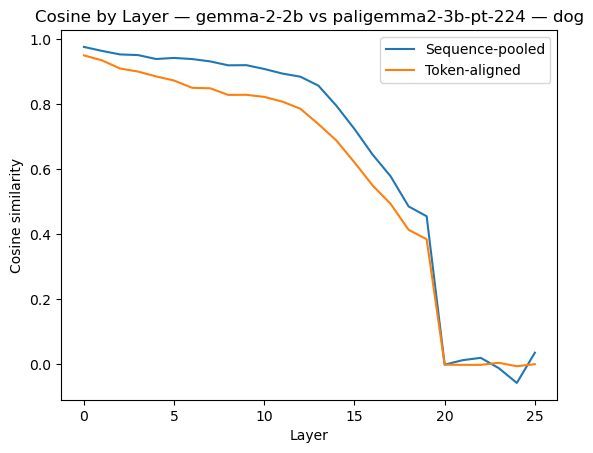

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 2.20 GiB. GPU 1 has a total capacity of 44.38 GiB of which 1.76 GiB is free. Process 549087 has 10.90 GiB memory in use. Process 728996 has 31.72 GiB memory in use. Of the allocated memory 26.74 GiB is allocated by PyTorch, and 3.97 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 2.20 GiB. GPU 2 has a total capacity of 44.38 GiB of which 1.71 GiB is free. Process 549087 has 10.91 GiB memory in use. Process 728996 has 31.75 GiB memory in use. Of the allocated memory 26.75 GiB is allocated by PyTorch, and 3.99 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting

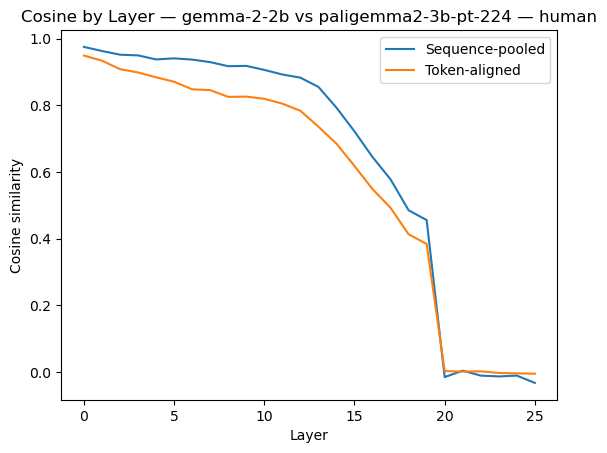

In [14]:
import numpy as np
import gc, torch

layers_to_test = list(range(26)) # gemma-2 doesn't have 27 layers, only 0-25
model1_name = "google/gemma-2-2b"
model2_name = "google/paligemma2-3b-pt-224"
model1 = load_models_with_eval(model1_name, DEVICE_1)
model1.eval()
model2 = load_models_with_eval(model2_name, DEVICE_2)
model2.eval()
# data_name_list = ['cat', 'dog', 'human']
data_name_list = [ 'dog', 'human']
for texts, labels, data_name in zip(texts_list, labels_list, data_name_list):
    cos_seq_means = []
    cos_tok_means = []

    # OPTIONAL: padding mask if you have one (bool [N, T]), else set to None
    pad_mask = None
    with torch.inference_mode():
        As = get_acts(model1, texts, layer, model1_name, DEVICE_1)  # [N, T, D]
        Bs = get_acts(model2, texts, layer, model2_name, DEVICE_2)  # [N, T, D]
    
    for layer in layers_to_test:
        
        A = As[layer]
        B = Bs[layer]
        cos_seq = cosine_sequence_mean(A, B, device='cpu')  # or pick a specific GPU
        cos_tok = cosine_token_aligned_mean(A, B, mask=pad_mask, device='cpu')

        cos_seq_means.append(cos_seq)
        cos_tok_means.append(cos_tok)

        print(f"Layer {layer:02d} | seq-pooled: {cos_seq:.4f} | token-aligned: {cos_tok:.4f}")

        del A, B
        gc.collect()
        torch.cuda.empty_cache()

    cos_seq_means = np.array(cos_seq_means, dtype=np.float32)
    cos_tok_means = np.array(cos_tok_means, dtype=np.float32)

    # # save for plotting later
    # np.savez(f"../figs_tabs/{data_name}/cosine_sim_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.npz",
    #          layers=np.array(layer_to_test),
    #          cos_seq_means=cos_seq_means,
    #          cos_tok_means=cos_tok_means)
    # Make output dir per concept
    outdir = f"../figs_tabs/{data_name}/"
    os.makedirs(outdir, exist_ok=True)

    m1_short = model1_name.split('/')[-1]
    m2_short = model2_name.split('/')[-1]

    # --- Figure: Cosine (sequence-pooled vs token-aligned) by layer ---
    plt.figure()
    plt.plot(layers_to_test, cos_seq_means)
    plt.plot(layers_to_test, cos_tok_means)
    plt.xlabel('Layer')
    plt.ylabel('Cosine similarity')
    plt.title(f"Cosine by Layer — {m1_short} vs {m2_short} — {data_name}")
    plt.legend(['Sequence-pooled', 'Token-aligned'])
    plt.savefig(os.path.join(outdir, f"cosine_by_layer_{m1_short}_{m2_short}.png"),
                dpi=150, bbox_inches='tight')
    plt.show()

    # (Optional) also persist a compact TSV for quick inspection
    with open(os.path.join(outdir, f"cosine_by_layer_{m1_short}_{m2_short}.tsv"), "w") as f:
        f.write("layer\tcos_seq\tcos_tok\n")
        for L, cseq, ctok in zip(layers_to_test, cos_seq_means, cos_tok_means):
            f.write(f"{int(L)}\t{float(cseq):.6f}\t{float(ctok):.6f}\n")


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

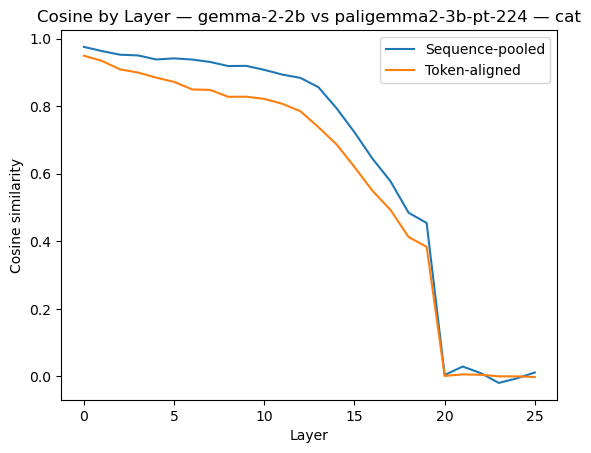

In [13]:
# --- Figure: Cosine (sequence-pooled vs token-aligned) by layer ---
layers_to_test = list(range(26))
plt.figure()
plt.plot(layers_to_test, cos_seq_means)
plt.plot(layers_to_test, cos_tok_means)
plt.xlabel('Layer')
plt.ylabel('Cosine similarity')
plt.title(f"Cosine by Layer — {m1_short} vs {m2_short} — {data_name}")
plt.legend(['Sequence-pooled', 'Token-aligned'])
plt.savefig(os.path.join(outdir, f"cosine_by_layer_{m1_short}_{m2_short}.png"),
            dpi=150, bbox_inches='tight')
plt.show()

# All probe exps

In [ ]:
# load models
model1_names = ["google/gemma-2-2b", "google/paligemma2-3b-pt-224"]
model2_names = ["google/gemma-2-2b", "google/paligemma2-3b-pt-224"]
data_name_list = ['cat', 'dog', 'human']
for texts, labels, data_name in zip(texts_list, labels_list, data_name_list):
    for model1_name in model1_names:
        for model2_name in model2_names:

            model1 = load_models_with_eval(model1_name, DEVICE_1)
            model2 = load_models_with_eval(model2_name, DEVICE_2)

            # # Dummy activations (replace with real data)
            # gemma_activations = np.random.randn(1000, 768)  # 1000 samples, 768 dims
            # gemma_labels = np.random.randint(0, 2, 1000)    # binary cat/dog labels

            # polygemma_activations = np.random.randn(200, 768)  # 200 test samples
            # polygemma_labels = np.random.randint(0, 2, 200)

            layer_to_test = list(range(1, 27))
            all_results = []
            # Run experiment per layer
            for layer in layer_to_test:
                # Produce activation-label pairs
                with torch.inference_mode():
                    model1_activations = get_acts(model1, texts, layer, model1_name, DEVICE_1)
                    model2_activations = get_acts(model2, texts, layer, model2_name, DEVICE_2)

                # === Run probe experiment ===
                results = experiment.run_experiment(
                    model1_activations, labels,
                    model2_activations, labels
                )
                # Cosine similarity
                cos_sim = 
                all_results.append(results)

                print(f"\n=== LAYER {layer} RESULTS ===")
                print(f"Train Accuracy: {results['sklearn']['train_acc']:.4f}")
                print(f"Test Accuracy: {results['sklearn']['test_acc']:.4f}")
                print("Classification Report:")
                print(results['sklearn']['classification_report'])
                      
                 
                print(f"Cosine similarity: {}")
                      
                # Save results
                os.makedirs(f"../output/{data_name}", exist_ok=True)
                experiment.save_results(results, f"../output/{data_name}/linear_probing_results_{layer}_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.json")

                # Save misclassified examples
                if 'y_test' in results['sklearn'] and 'y_pred' in results['sklearn']:
                    mis_indices = [i for i, (yt, yp) in enumerate(zip(
                        results['sklearn']['y_test'], results['sklearn']['y_pred']
                    )) if yt != yp]
                    mis_info = [
                        {
                            'text': cat_texts[i],  # assuming you meant cat_texts not text
                            'true_label': int(results['sklearn']['y_test'][i]),
                            'pred_label': int(results['sklearn']['y_pred'][i])
                        }
                        for i in mis_indices
                    ]
                    os.makedirs(f"../output/{data_name}/{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}", exist_ok=True)
                    with open(f"../output/{data_name}/{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}/misclassified_layer_{layer}.json", 'w') as f:
                        json.dump(mis_info, f, indent=2)
                else:
                    print("Warning: 'y_test' or 'y_pred' not found in results; misclassifications not saved.")

                del model1_activations, model2_activations, results
                gc.collect()
                torch.cuda.empty_cache()

            # ===== Plot Train and Test Accuracy Across Layers =====
            import matplotlib.pyplot as plt

            layers = layer_to_test
            train_accs = [res['sklearn']['train_acc'] for res in all_results]
            test_accs = [res['sklearn']['test_acc'] for res in all_results]

            plt.figure()
            plt.plot(layers, train_accs)
            plt.plot(layers, test_accs)
            plt.xlabel('Layer')
            plt.ylabel('Accuracy')
            plt.title(f"Train and Test Accuracy by Layer_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}. Concept: {data_name}")
            plt.legend(['Train', 'Test'])
            os.makedirs(f"../figs_tabs/{data_name}/", exist_ok=True)
            plt.savefig(f"../figs_tabs/{data_name}/Linear Probe Train and Test Accuracy by Layer_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.png")
            plt.show()

